# PupilExplore

## 0.导入包

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal # 主要负责滤波
import scipy # 主要负责插值
import random
import pickle  # pandas自带一个pickle

## 1. Utils

获取实验的轮数

In [2]:
def get_trail_num():
    trail_num = len(pupil_event.index.levels[0])
    return trail_num

检查事件的步长是否相同

In [3]:
def is_same_event_step(df):
    a = df[df[df.columns[1]].str.contains("TRIALID")].index
    event_step = a[1]-a[0]
    assert(np.diff(a) == (event_step)).all(),"The OneShot event Data have different step"
    print("Pass event step test")
    
    return event_step

设置Pupil_event的索引

In [4]:
def set_event_id(df):
    # 如果已经设置过索引，就不在设置，否则会报错
    if 'trail_id' in df.index.names:
        return None
    trail_num = len(df[df[df.columns[1]].str.contains("TRIALID")].index)
    temp = np.ones(shape = (trail_num*event_step),dtype = int)
    for i in range(trail_num):
        temp[i*event_step:i*event_step+event_step] = temp[i*event_step:i*event_step+event_step] * (i+1)
    df["trail_id"] = temp
    df.set_index(["trail_id","timestamp"],inplace =True)

设置pupil_data的索引

In [5]:
def set_data_id(df):
    if df.index.name:
        print("未执行")
        return None
    else:
        df.set_index([df.columns[0]],inplace =True)

获取指定trail的数据(pupil_data和pupil_event)

In [6]:
def get_trail_segment(df_data,df_event,num_list:list):
    '''
    给定trail_num,返回分割后的pupil_data和pupil_event,需要以列表的形式，如果只有一个元素，也需要是列表
    范围[1,trail_num]
    '''
    trail_num = len(df_event.index.levels[0])
    for num in num_list:
        assert 1<= num <= trail_num, f"the legal trail_num between 1 and {trail_num},check the input "
    # 开始时间应该是trail的开始时间
    # 结束时间是下一个trail的开始时间
    ans_pupil_data = pd.DataFrame()
    ans_pupil_event = pd.DataFrame()
    for num in num_list:
        temp = df_event.loc[num].index
        start_time,end_time = temp[0],temp[-1]
        # 筛选时间段
        ans_pupil_data = ans_pupil_data.append(df_data[start_time:end_time])
        # 这句话写错了
        ans_pupil_event = ans_pupil_event.append(df_event.loc[[num]])# ！！！！！！！！
#     print("ok")
#     set_data_id(ans_pupil_data)
#     print(ans_pupil_event)
#     # set_event_id(ans_pupil_event)
    return ans_pupil_data,ans_pupil_event

计算采样率

In [7]:
def set_fs(df):
    fs = len(df)/(df.index[-1]-df.index[0]).value*10e8
    fs = int(round(fs,0))
    return fs
    

数据降采样

In [8]:
def downsample_pupil_data():
    def check_fs(df,min_len):
        # 对降采样的结果进行检查
        for i in range(trail_num):
            temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[i+1])
            if len(temp_seg)!=min_len:
                print("降采样失败")
                break
        print(("降采样成功"))
    temp_len = []
    min_len = np.inf
    max_len = -np.inf
    for i in range(trail_num):
        temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[i+1])
        length = len(temp_seg)
        temp_len.append(length)
        if length<min_len:
            min_len = length
        elif length>max_len:
            max_len = length
    for i in range(trail_num):
        temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[i+1])
        need_del_num = len(temp_seg)-min_len
        random.seed(9617)
        if need_del_num >0:
            need_del_index = random.choices(temp_seg.index,k = need_del_num)
            pupil_data.drop(labels = need_del_index,axis = 0,inplace= True )
    check_fs(pupil_data,min_len)

### 1.1 滤波

赫尔移动平均

In [9]:
# https://stackoverflow.com/questions/64500904/how-to-calculate-hull-moving-average-in-python
def WMA(s, period):
       return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)

def HMA(s, period):
       return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))
def HMA_pupil(narray,period):
    
    return HMA(WMA(narray,period),period)    

移动平均滑窗

In [10]:
# 是否需要改名为SMA？
def move_average(df,window_size = 5):
    return df.rolling(window = window_size).sum()
### 调用方式
# b = pupil_data[test_time_start:test_time_end].rolling(window = 5).sum()
# plt.figure(figsize=(20,10))
# b['pupil_size'].plot()

信号光滑--hanning

In [11]:
def smooth_window(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window should be one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='same')
    return y[(window_len-1):(-window_len+1)]
# # 调用方法
# a = smooth_window(temp_seg["pupil_size"])

### 1.2 眨眼检测

In [12]:
# 算法1——velocity
def detect_blinks_velocity(sy, smooth_winsize, vel_onset, vel_offset, min_onset_len=5, min_offset_len=5):
    """
    Detect blinks as everything between a fast downward and a fast upward-trending PD-changes.
    
    This works similarly to :py:func:`blink_onsets_mahot()`.
    
    Parameters
    ----------
    sy: np.array
        pupil data
    smooth_winsize: int (odd)
        size of the Hanning-window in sampling points
    vel_onset: float
        velocity-threshold to detect the onset of the blink
        negative velocity that needs to be crossed; arbitrary units that depend on
        sampling rate etc
    vel_offset: float
        velocity-threshold to detect the offset of the blink
    min_onset_len: int
        minimum number of consecutive samples that cross the threshold to detect onset
    min_offset_len: int
        minimum number of consecutive samples that cross the threshold to detect offset
    """
    # generate smoothed signal and velocity-profile
    sym=smooth_window(sy, smooth_winsize, "hanning") # 完成
    vel=np.r_[0,np.diff(sym)] # 在累差前面添加一个0
    n=sym.size # 获得平滑后的长度
    # vel是变化速度
    # find first negative vel-crossing 
    onsets=np.where(vel<=vel_onset)[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
    onsets_ixx=np.r_[np.diff(onsets),10]>1  # 间隔大于1得索引
    onsets_len=np.diff(np.r_[0,np.where(onsets_ixx)[0]])  
    onsets=onsets[onsets_ixx]  # 速度符合要求的起始点
    onsets=onsets[onsets_len>min_onset_len]  # 筛选每个起始点对应的长度，长度定义：一个起点到下一个起点的索引距离
                                     
    ## offset finding
    offsets=np.where(vel>=vel_offset)[0]
    offsets_ixx=np.r_[10,np.diff(offsets)]>1
    offsets_len=np.diff(np.r_[np.where(offsets_ixx)[0],offsets.size])
    offsets=offsets[offsets_ixx]
    offsets=offsets[offsets_len>min_offset_len]
    
    
    ## find corresponding on- and off-sets,循环套娃，直到onsets和offsets结束
    blinks=[]
    on=onsets[0]
    while on is not None:
        offs=offsets[offsets>on]
        off=offs[0] if offs.size>0 else n
        blinks.append([on,off])
        ons=onsets[onsets>off]
        on=ons[0] if ons.size>0 else None
    # 扩展眨眼的范围
    ## if on- off-sets fall in a zero-region, grow until first non-zero sample
    blinks2=[]
    for (on,off) in blinks:
        while(on>0 and sy[on]==0):
            on-=1
        while(off<n-1 and sy[off]==0):
            off+=1
        blinks2.append([on,off])
    return np.array(blinks2)

In [13]:
# 算法2？？？？算不上算法
def detect_blinks_zero(sy, min_duration, blink_val=0):
    """
    Detect blinks as consecutive sequence of `blink_val` (f.eks., 0 or NaN) of at least
    `min_duration` successive values in the signal `sy`.
    Detected blinks are put a matrix `blinks` (nblinks x 2) where start and end
    are stored as indexes.
    
    Parameters
    ----------
    sy: np.array (float)
        signal
    min_duration: int
        minimum number of consecutive samples for a sequence of missing numbers to be treated as blink
    blink_val: 
        "missing value" code
    
    Returns
    -------
    np.array (nblinks x 2) containing the indices of the start/end of the blinks
    """
    x=np.r_[0, np.diff((sy==blink_val).astype(np.int))]
    starts=np.where(x==1)[0]
    ends=np.where(x==-1)[0]-1
    if sy[0]==blink_val: ## first value missing?
        starts=np.r_[0,starts]    
    if ends.size!=starts.size: 
        ## is the first start earlier than the first end?
        if starts[0]>ends[0]:
            ends=ends[1:] # drop first end
        else:
            starts=starts[:-1] # drop last start
    print(ends)
    if ends[-1]==x.size:
        ends[-1]-=1
    blinks=[ [start,end] for start,end in zip(starts,ends) if end-start>=min_duration]
    return np.array(blinks)

In [14]:
# 算法3——反向velocity
def reverse_detect_blinks_velocity(sy, smooth_winsize, vel_onset, vel_offset, min_onset_len=5, min_offset_len=5):
    """
    Detect blinks as everything between a fast downward and a fast upward-trending PD-changes.
    
    This works similarly to :py:func:`blink_onsets_mahot()`.
    
    Parameters
    ----------
    sy: np.array
        pupil data
    smooth_winsize: int (odd)
        size of the Hanning-window in sampling points
    vel_onset: float
        velocity-threshold to detect the onset of the blink
        negative velocity that needs to be crossed; arbitrary units that depend on
        sampling rate etc
    vel_offset: float
        velocity-threshold to detect the offset of the blink
    min_onset_len: int
        minimum number of consecutive samples that cross the threshold to detect onset
    min_offset_len: int
        minimum number of consecutive samples that cross the threshold to detect offset
    """
    # generate smoothed signal and velocity-profile
    sym=smooth_window(sy, smooth_winsize, "hanning") # 完成
    vel=np.r_[0,np.diff(sym)] # 在累差前面添加一个0
    n=sym.size # 获得平滑后的长度
    # vel是变化速度
    # find first negative vel-crossing 
    onsets=np.where(vel<=vel_onset)[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
    onsets_ixx=np.r_[np.diff(onsets),10]>1  # 间隔大于1得索引
    onsets_len=np.diff(np.r_[0,np.where(onsets_ixx)[0]])  
    onsets=onsets[onsets_ixx]  # 速度符合要求的起始点
    onsets=onsets[onsets_len>min_onset_len]  # 筛选每个起始点对应的长度，长度定义：一个起点到下一个起点的索引距离
                                     
    ## offset finding
    offsets=np.where(vel>=vel_offset)[0]
    offsets_ixx=np.r_[10,np.diff(offsets)]>1
    offsets_len=np.diff(np.r_[np.where(offsets_ixx)[0],offsets.size])
    offsets=offsets[offsets_ixx]
    offsets=offsets[offsets_len>min_offset_len]
    
    onsets,offsets = offsets,onsets
    ## find corresponding on- and off-sets,循环套娃，直到onsets和offsets结束
    blinks=[]
    on=onsets[0]
    while on is not None:
        offs=offsets[offsets>on]
        off=offs[0] if offs.size>0 else n
        blinks.append([on,off])
        ons=onsets[onsets>off]
        on=ons[0] if ons.size>0 else None
    # 扩展眨眼的范围
    ## if on- off-sets fall in a zero-region, grow until first non-zero sample
    blinks2=[]
    for (on,off) in blinks:
        while(on>0 and sy[on]==0):
            on-=1
        while(off<n-1 and sy[off]==0):
            off+=1
        blinks2.append([on,off])
    return np.array(blinks2)

In [15]:
# 核心的眨眼检测
def blinks_detect(data,min_duration_ms: float=20,strategies=["zero","velocity","reverse_velocity","mine_velocity"]):
    """
    min_duration的计算公式 一次眨眼0.2s=200ms     200/1000*100 = 20  这里的100是采样率  
    """
    winsize_ix = 7
    vel_onset = -2
    vel_offset = 2
    min_duration_ix=int(min_duration_ms/1000.*fs)
    min_onset_len, min_offset_len =1,1
    ## detect blinks with the different strategies
    if "velocity" in strategies:
        blinks_vel=detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
    if "reverse_velocity" in strategies:
        blinks_vel_2=reverse_detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
        blinks = blinks_vel_2
    if "mine_velocity" in strategies:
        blinks_vel_3= mine_detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
        blinks = blinks_vel_3
   
    # 用不上没有0值
#     if "zero" in strategies:
#         blinks_zero=detect_blinks_zero(data, 1)
#     else:
#         blinks_zero=np.array([])



#     for strat in strategies:
#         if strat == "velocity": 
#             blinks_vel=detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)    
#         elif "zero" in strategies:
#             blinks_zero=detect_blinks_zero(data, 1, blink_val)
#         else:
#             blinks_zero=np.array([])
    # 将眨眼区间融合
    ## merge the two blinks，将两个眨眼算法融合
#     blinks=helper_merge_blinks(blinks_vel, blinks_zero)
###################################
# 将眨眼区间融合
    # merge the two blinks，将两个眨眼算法融合
#     blinks=helper_merge_blinks(blinks_vel,blinks_vel_2)
###################################
#     blinks = blinks_vel
#     blinks = blinks_vel_2
    ans_blinks=np.array([[on,off] for (on,off) in blinks if off-on>=min_duration_ix])

    ans_blink_mask=np.zeros(data.size, dtype=np.int)

    for start,end in ans_blinks:
        ans_blink_mask[start:end]=1
    return ans_blinks,ans_blink_mask

In [16]:
# 对两个算法的结果进行合并
def helper_merge_blinks(b1,b2):
    if b1.size==0:
        return b2
    elif b2.size==0:
        return b1
    on=np.sort(np.concatenate( (b1[:,0], b2[:,0]) ))
    off=np.sort(np.concatenate( (b1[:,1], b2[:,1]) ))
    b=np.vstack((on,off)).T

    newb=[]
    on,off=b[0,:]
    for i in range(1,b.shape[0]):
        if b[i,0]<=off:
            # absorb onset from next 
            off=max(off,b[i,1])
        else:
            newb.append([on,off])
            on,off=b[i,:]
    off=b[-1,1]
    newb.append([on,off])
    return np.array(newb)

In [17]:
# 将相邻的眨眼合并
def blinks_merge(blinks,distance:float=100, remove_signal: bool=False):
    """
    Merge together blinks that are close together. 
    Some subjects blink repeatedly and standard detection/interpolation can result in weird results.
    This function simply treats repeated blinks as one long blink.

    Parameters
    ----------

    distance: float
        merge together blinks that are closer together than `distance` in ms
    remove_signal: bool
        if True, set all signal values during the "new blinks" to zero so 
        that :func:`.detect_blinks()` will pick them up; interpolation will work
        either way
    inplace: bool
        if `True`, make change in-place and return the object
        if `False`, make and return copy before making changes                                                    
    """
#     distance_ix=distance/fs*1000.
    distance_ix=distance/1000.*fs
    newblinks=[] 
    i=1
    cblink=blinks[0,:] ## start with first blink
    while(i<len(blinks)):
        if (blinks[i,0]-cblink[1])<=distance_ix:
            # merge
            cblink[1]=blinks[i,1]
        else:
            newblinks.append(cblink)
            cblink=blinks[i,:]
        i+=1            
    newblinks.append(cblink)
    newblinks=np.array(newblinks)       

    ans_blinks=newblinks

    ## set signal to zero within the new blinks
#     if remove_signal:
#         for start,end in obj.blinks:
#             obj.sy[start:end]=0

    return ans_blinks

返回统计信息

In [18]:
############## 待完成   #####################
def Stat_info(df):
    # 最大，最小，方差，眨眼次数
    pass
def summary_info(df):
    pass

## 2. 读取数据

In [19]:
# 这里的.dat后缀是随便取的，保存的格式还是csv格式，所以调用read_csv就能继续用
# 设置需要读取的文件名
Data_event = "sub22-005_events.csv"
Date_pupil = "sub22-005.dat"

In [20]:
# 读取两个文件
pupil_data = pd.read_csv("../Data/"+Date_pupil)
pupil_event = pd.read_csv("../Data/"+Data_event)
# 将两个字符串转变为时间序列格式，方便处理
pupil_event["timestamp"] = pd.to_datetime(pupil_event["timestamp"])
pupil_data["timestamp"] = pd.to_datetime(pupil_data["timestamp"]) 

## 3. 检查数据

In [21]:
# 确定事件步长
event_step = is_same_event_step(pupil_event)
event_step

Pass event step test


8

In [22]:
# 设置瞳孔事件索引
set_event_id(pupil_event)

In [23]:
# 设置瞳孔数据的索引
set_data_id(pupil_data)

In [24]:
# 检查瞳孔数据索引设置
pupil_data

,pupil_size,pupil_x,pupil_y
timestamp,,,
2021-11-04 08:07:50.855,96,1387.22,391.002
2021-11-04 08:07:50.865,95,1386.48,391.712
2021-11-04 08:07:50.875,96,1385.55,392.301
2021-11-04 08:07:50.885,97,1385.65,394.228
2021-11-04 08:07:50.895,97,1384.57,394.236
...,...,...,...
2021-11-04 09:01:45.984,99,1353.21,442.819
2021-11-04 09:01:45.994,100,1352.92,442.970
2021-11-04 09:01:46.004,99,1352.76,442.369


In [25]:
## 检查瞳孔事件索引设置
pupil_event

message
trail_id timestamp                                                 
1        2021-11-04 08:07:50.862                          TRIALID 1
         2021-11-04 08:07:52.364  !V TRIAL_VAR transitions variable
         2021-11-04 08:07:52.865               !V TRIAL_VAR stake 5
         2021-11-04 08:07:54.011      !E TRIAL_EVENT_VAR response_1
         2021-11-04 08:07:54.872    !E TRIAL_EVENT_VAR monster_show
...                                                             ...
294      2021-11-04 09:01:39.890      !E TRIAL_EVENT_VAR response_1
         2021-11-04 09:01:41.034    !E TRIAL_EVENT_VAR monster_show
         2021-11-04 09:01:41.850      !E TRIAL_EVENT_VAR response_2
         2021-11-04 09:01:43.035          !E TRIAL_EVENT_VAR reward
         2021-11-04 09:01:46.027                          TRIAL_END

[2352 rows x 1 columns]

## 4. 获取数据的信息

In [26]:
# 确定瞳孔数据的长度(采样频率)
def set_fs(df):
    fs = len(df)/(df.index[-1]-df.index[0]).value*10e8
    fs = int(round(fs,0))
    return fs
fs  = set_fs(pupil_data)
fs

100

In [27]:
# 确定实验的次数
trail_num = get_trail_num()

## 5. 数据总体预览

In [28]:
# 对pupildata进行降采样，方便进行下一步    
downsample_pupil_data()

降采样成功


In [29]:
# 这里的shape将来需要优化，这里就不修改了
temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[1])
temp_pupil_data_array = []
###  对所有的trail进行降采样
for i in range(trail_num):
    a,_= get_trail_segment(pupil_data,pupil_event,[i+1])
    temp_pupil_data_array.append(a.pupil_size.values)
temp_pupil_data_array = np.array(temp_pupil_data_array)
ans = np.mean(temp_pupil_data_array,axis = 0)

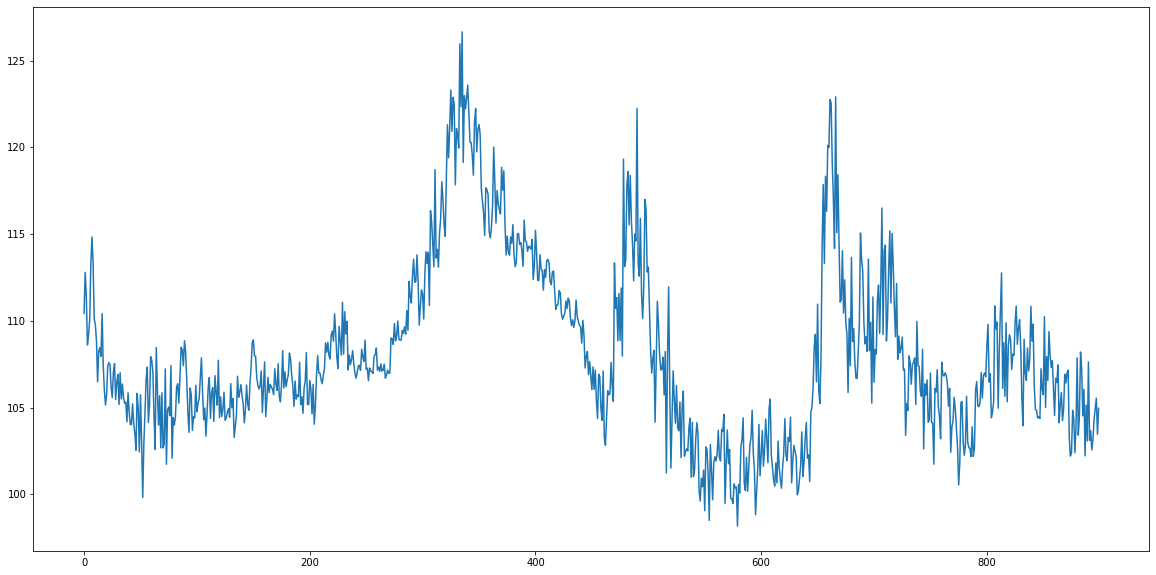

In [30]:
# 感觉可以
plt.figure(figsize=(20,10))
plt.plot(ans)

## 6. 第一个trail演示

<AxesSubplot:xlabel='timestamp'>

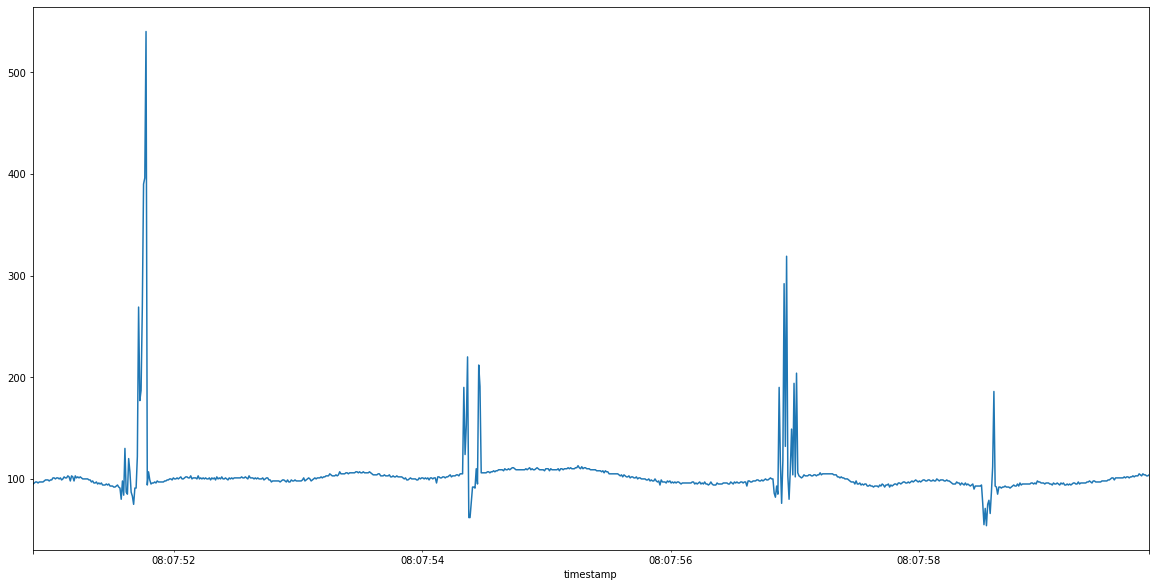

In [31]:
# 取出第一组数据进行实验
temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[1])
plt.figure(figsize=(20,10))
temp_seg["pupil_size"].plot()

### 6.1 光滑后的数据

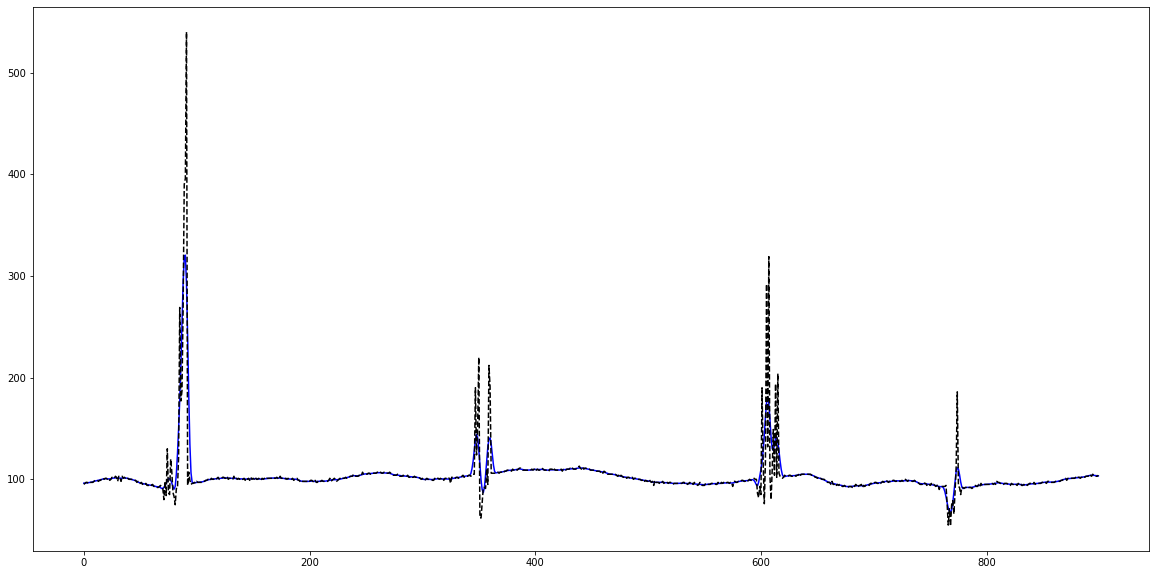

In [32]:
a = smooth_window(temp_seg["pupil_size"])
plt.figure(figsize=(20,10))
plt.plot(range(900),a,color="blue")
plt.plot(range(900),temp_seg["pupil_size"],color="black",linestyle="--")
# plt.plot(x,y_1,label="自己")
# plt.plot(x,y_2,label="同桌",,linestyle="--")

### 6.2 眨眼检测

In [33]:
ans_blinks,ans_blink_mask = blinks_detect(temp_seg["pupil_size"].values,strategies=["reverse_velocity"])

c:\users\wqj\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


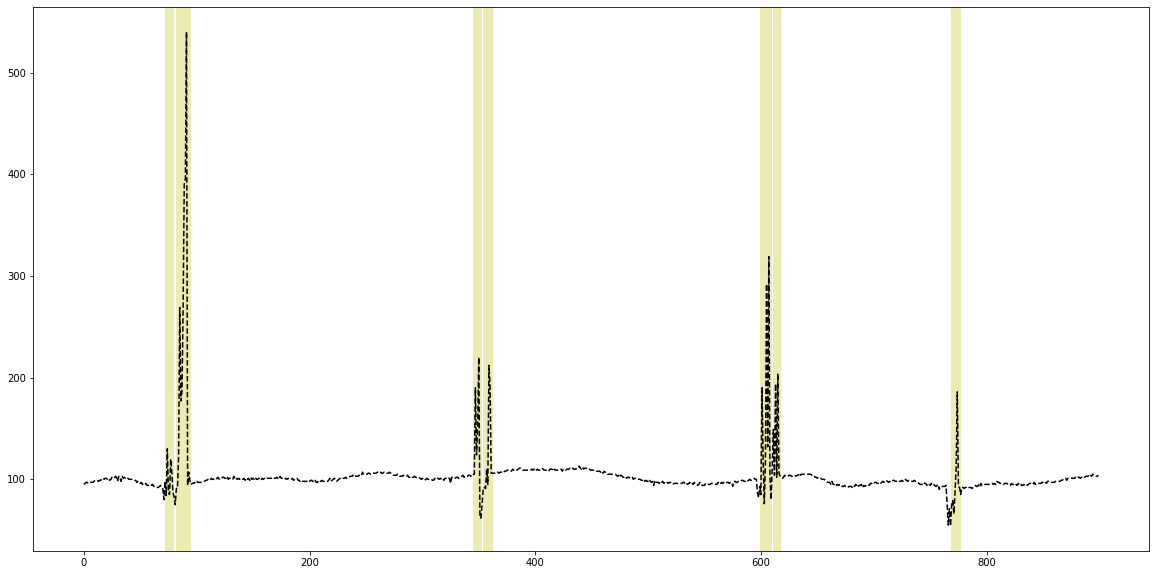

In [34]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg["pupil_size"],color="black",linestyle="--")
for i,j in ans_blinks:
    plt.axvspan(xmin=i, xmax=j, facecolor="y", alpha=0.3)
plt.show()

### 6.3 合并眨眼区间

In [35]:
ans_blinks_1 = blinks_merge(ans_blinks,distance=100, remove_signal=False)

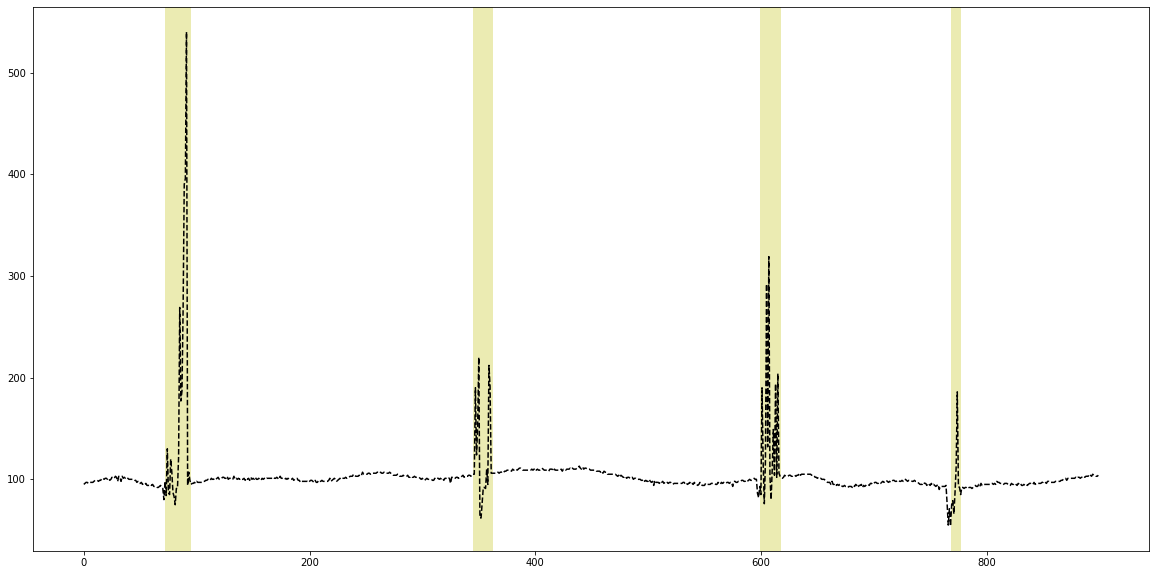

In [36]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg["pupil_size"],color="black",linestyle="--")
for i,j in ans_blinks_1:
    plt.axvspan(xmin=i, xmax=j, facecolor="y", alpha=0.3)
plt.show()
# 合并成功

### 6.4 对合并区间进行插值

In [37]:
interpolated_mask=np.zeros(temp_seg.shape[0])
interpolated_mask.shape

(900,)

In [38]:
interpolated_mask=np.zeros(temp_seg.shape[0])
for on,off in ans_blinks_1:
    interpolated_mask[on:off]=1

In [39]:
temp_seg.index[interpolated_mask==0]

DatetimeIndex(['2021-11-04 08:07:50.865000', '2021-11-04 08:07:50.875000',
               '2021-11-04 08:07:50.885000', '2021-11-04 08:07:50.895000',
               '2021-11-04 08:07:50.905000', '2021-11-04 08:07:50.915000',
               '2021-11-04 08:07:50.925000', '2021-11-04 08:07:50.935000',
               '2021-11-04 08:07:50.945000', '2021-11-04 08:07:50.955000',
               ...
               '2021-11-04 08:07:59.765000', '2021-11-04 08:07:59.775000',
               '2021-11-04 08:07:59.785000', '2021-11-04 08:07:59.795000',
               '2021-11-04 08:07:59.805000', '2021-11-04 08:07:59.815000',
               '2021-11-04 08:07:59.825000', '2021-11-04 08:07:59.835000',
               '2021-11-04 08:07:59.845000', '2021-11-04 08:07:59.855000'],
              dtype='datetime64[ns]', name='timestamp', length=831, freq=None)

In [40]:
f=scipy.interpolate.interp1d(np.float64(temp_seg.index.values)[interpolated_mask==0], temp_seg["pupil_size"][interpolated_mask==0], 
                                     kind="cubic", bounds_error=False, fill_value=0)
temp_seg_inter_1 = f(np.float64(temp_seg.index.values))

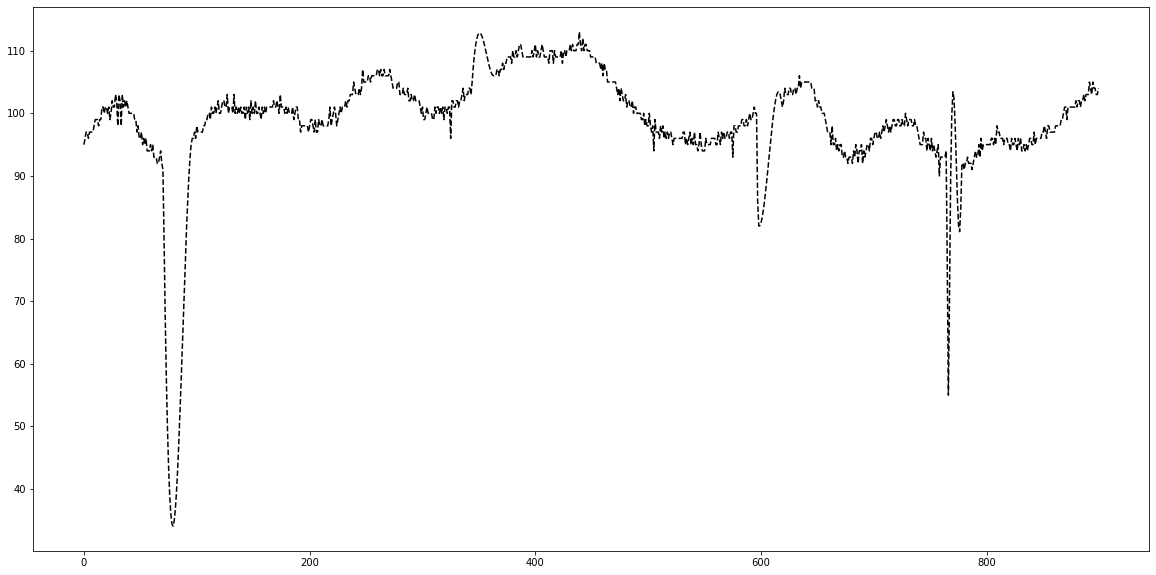

In [41]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")

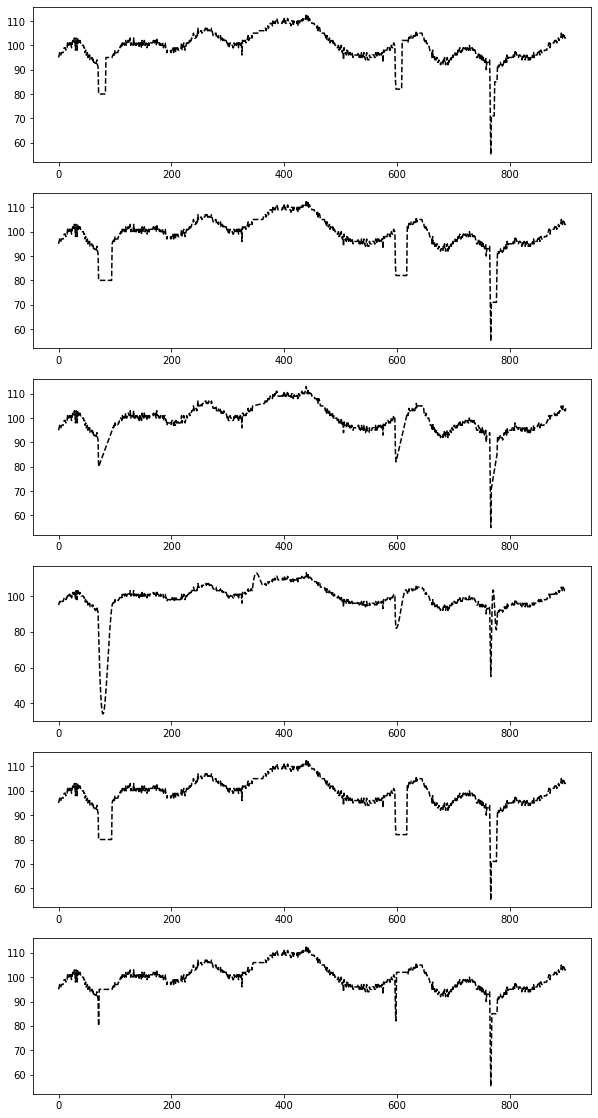

In [42]:
plt.figure(figsize=(10,20))
kind_lst = ['nearest', 'zero', 'slinear', 'cubic', 'previous',  'next']
for k in range(len(kind_lst)):
    f=scipy.interpolate.interp1d(np.float64(temp_seg.index.values)[interpolated_mask==0], temp_seg["pupil_size"][interpolated_mask==0], 
                                 kind=kind_lst[k], bounds_error=False, fill_value=0)
    temp_seg_inter_1 = f(np.float64(temp_seg.index.values))
    plt.subplot(len(kind_lst),1,k+1)
    plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--",label=kind_lst[k])

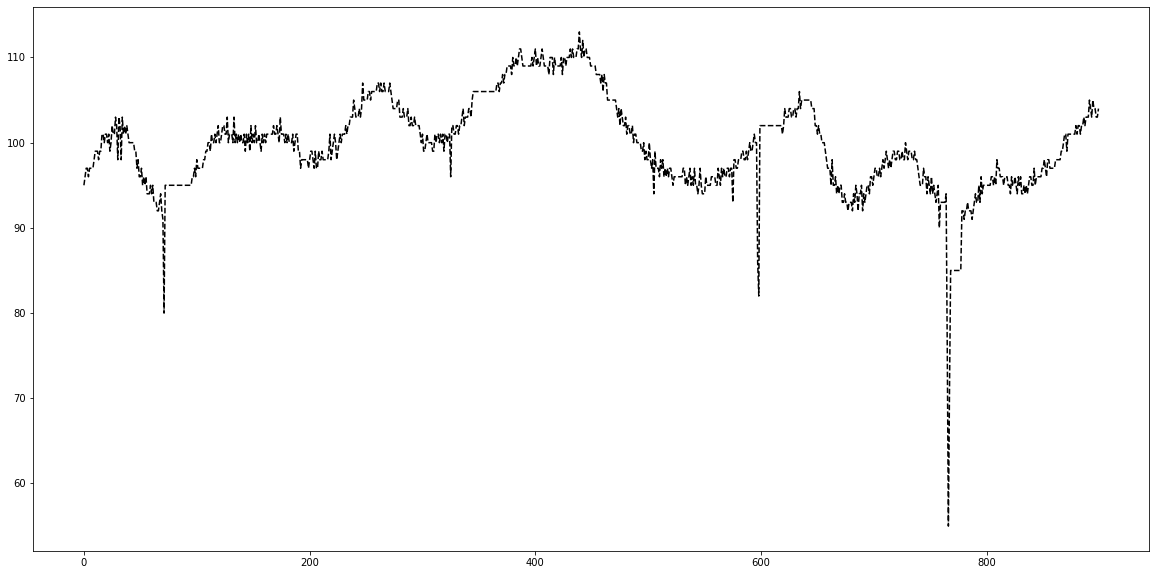

In [43]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")

### 6.5 对处理结果进行修正

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

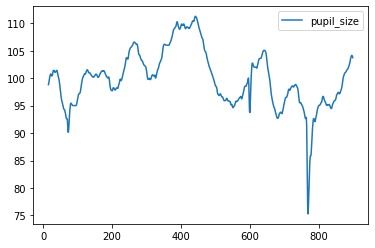

In [44]:
####HMA#####
# https://stackoverflow.com/questions/64500904/how-to-calculate-hull-moving-average-in-python
a = pd.DataFrame(columns=["pupil_size"],data = temp_seg_inter_1)
b = HMA_pupil(a,period = 8)
plt.figure(figsize=(20,10))
b.plot()

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

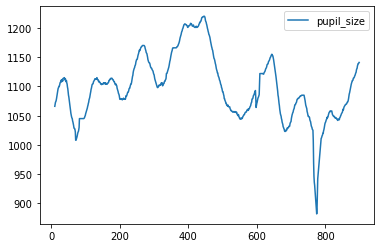

In [45]:
###### 移动平均滤波  #####
# def move_average(df,window_size = 5):
#     return df.rolling(window = window_size).sum()
a = pd.DataFrame(columns=["pupil_size"],data = temp_seg_inter_1)
b = move_average(a,window_size =11)
plt.figure(figsize=(20,10))
b.plot()

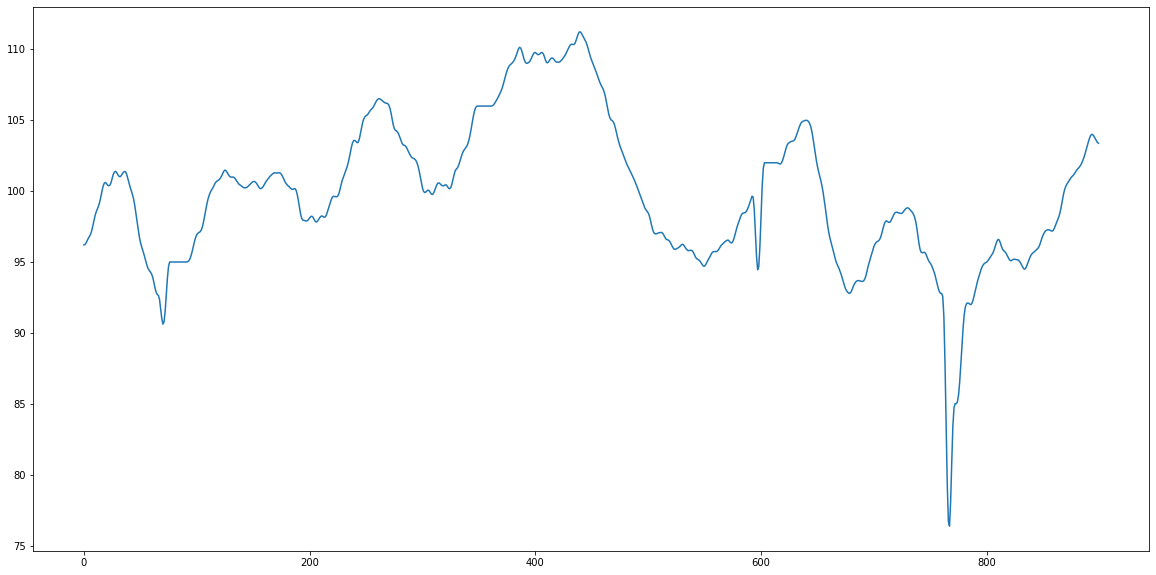

In [46]:
##### 信号处理 #######
b = smooth_window(temp_seg_inter_1,window_len=11)
plt.figure(figsize=(20,10))
plt.plot(range(900),b)

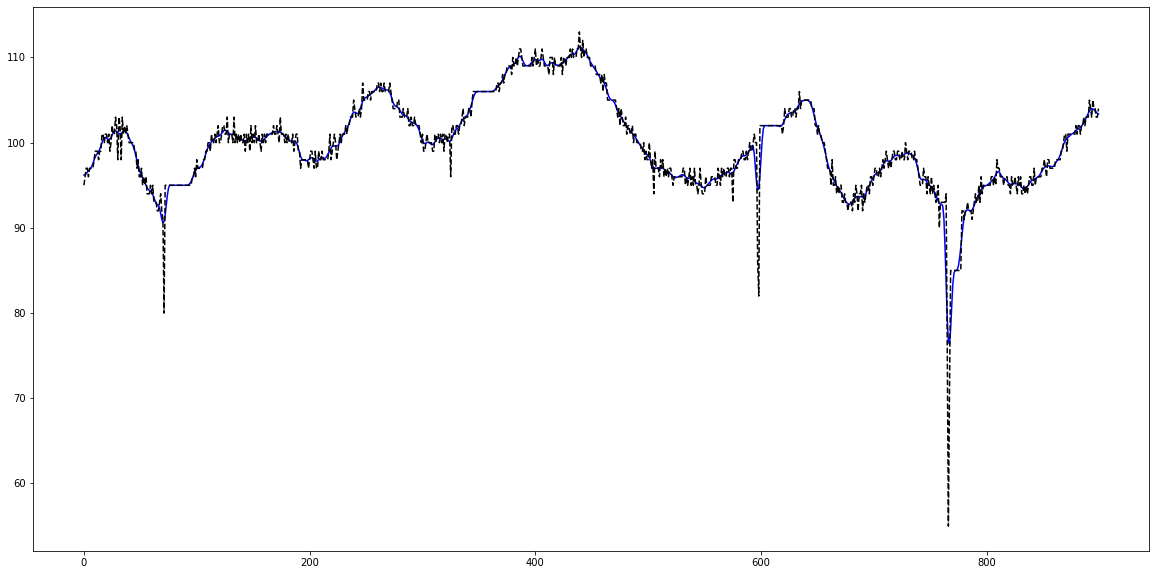

In [47]:
a = smooth_window(temp_seg_inter_1)
plt.figure(figsize=(20,10))
plt.plot(range(900),a,color="blue")
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")

总结：  
不能使用均值滤波，还是需要对眨眼进行检测

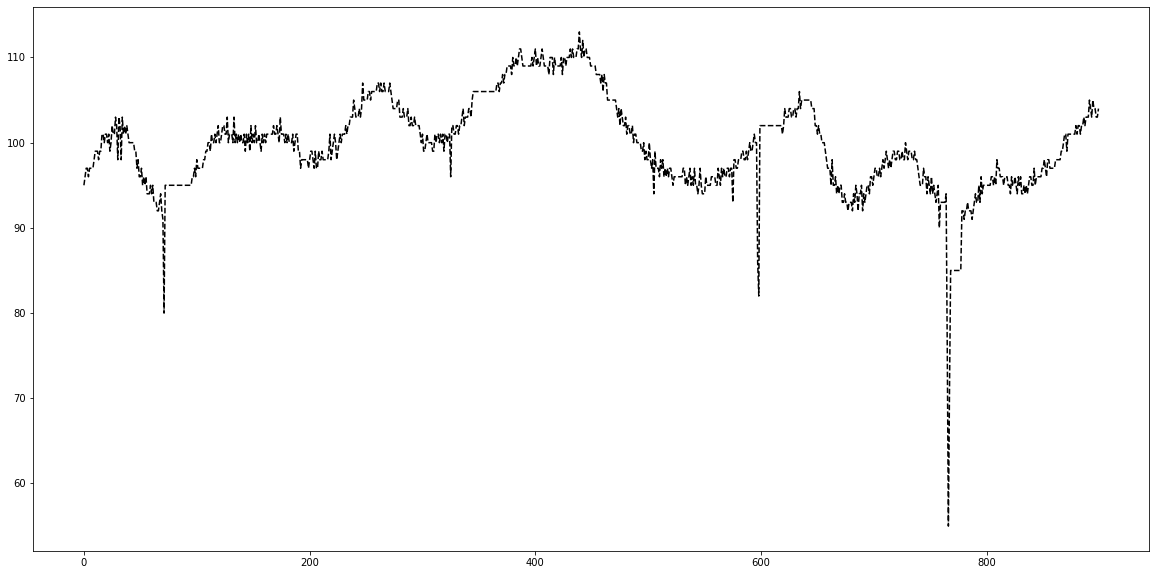

In [48]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")

In [ ]:
min_duration_ix = 5  # 一个眨眼的持续时间不能小于5个采样单位
blinks_vel= detect_blinks_velocity(data, smooth_winsize=7, vel_onset=-2, vel_offset=2, min_onset_len=5, min_offset_len=5)

In [85]:
a = np.array([2,1,3,4,6,7,3,0,0,0,9,8,1,2,3])

In [89]:
a>3

array([False, False, False,  True,  True,  True, False, False, False,
       False,  True,  True, False, False, False])

In [93]:
a>3

array([False, False, False,  True,  True,  True, False, False, False,
       False,  True,  True, False, False, False])

In [94]:
a==0

array([False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False])

In [95]:
np.logical_or(a>3,a==0)

array([False, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False])

In [96]:
np.where(np.logical_or(a>3,a==0))

(array([ 3,  4,  5,  7,  8,  9, 10, 11], dtype=int64),)

In [280]:
# 算法5——Myvelocity
def mine_detect_blinks_velocity(data, smooth_winsize, vel_onset, vel_offset, min_onset_len=5, min_offset_len=5):
    min_duration_ix = 15 
    vel_onset = -2
    vel_offset =2
    min_onset_len = 5
    min_offset_len = 20
    sym=smooth_window(data, window_len=7,window='hanning')
    # sym = data
    vel=np.r_[0,np.diff(sym)] # 在累差前面添加一个0
    n=sym.size # 获得平滑后的长度
    # vel是变化速度
    # find first negative vel-crossing 
    onsets=np.where(vel<=vel_onset)[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
    onsets_ixx=np.r_[onsets[0]-1,np.diff(onsets)]>1# 间隔大于1得索引
    onsets_len=np.diff(np.r_[0,onsets[onsets_ixx]])
    onsets=onsets[onsets_ixx]
    onsets=onsets[onsets_len>min_onset_len]

#     offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0]
#     offsets_ixx=np.r_[np.diff(offsets),5]>1
#     offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
#     offsets=offsets[offsets_ixx]
#     offsets=offsets[offsets_len>min_offset_len]
    
    
    offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0]
    temp = []
    i,j =0,1
    while i < len(offsets)-1 and j < len(offsets)-1:
        if offsets[j]-offsets[i]<min_offset_len:
            j+=1
            continue
        else:
            temp.append(offsets[j-1])
            i=j
            j+=1
    offsets = np.array(temp)     
    
    
    ## find corresponding on- and off-sets,循环套娃，直到onsets和offsets结束
    blinks=[]
    if len(onsets)<1 or len(offsets)<1:   # 否则没有检测到眨眼就会报错
        return None
    on=onsets[0]
    while on is not None:
        offs=offsets[offsets>on]
        off=offs[0] if offs.size>0 else n
        blinks.append([on,off])
        ons=onsets[onsets>off]
        on=ons[0] if ons.size>0 else None
    # 扩展眨眼的范围
    ## if on- off-sets fall in a zero-region, grow until first non-zero sample
    blinks2=[]
    for (on,off) in blinks:
        while(on>0 and vel[on]==0):
            on-=1
        while(off<n-1 and vel[off]==0):
            off+=1
        blinks2.append([on,off])
    return np.array(blinks2)
#     blinks=[]
#     if len(onsets)<1:
#         print("眨眼区间为0，需要重新调整")
#     on=onsets[0]
#     while on is not None:
#         offs=offsets[offsets>on]
#         off=offs[0] if offs.size>0 else n
#         blinks.append([on,off])
#         ons=onsets[onsets>off]
#         on=ons[0] if ons.size>0 else None
#     ## if on- off-sets fall in a zero-region, grow until first non-zero sample
#     blinks2=[]
#     for (on,off) in blinks:
#         while(on>0 and data[on]==0):
#             on-=1
#         while(off<n-1 and data[off]==0):
#             off+=1
#         blinks2.append([on,off])
#     blinks3 = []
#     for (on,off) in blinks2:
#         while(on>0 and np.diff(sym)[on]==0):
#             on-=1
#         while(off<n-1 and np.diff(sym)[on]==0):
#             off+=1
#         blinks3.append([on,off])
#     return np.array(blinks2)

In [281]:
# 核心的眨眼检测
def blinks_detect(data,min_duration_ms: float=20,strategies=["zero","velocity","reverse_velocity","mine_velocity"]):
    """
    min_duration的计算公式 一次眨眼0.2s=200ms     200/1000*100 = 20  这里的100是采样率  
    """
    winsize_ix = 7
    vel_onset = -2
    vel_offset = 2
    min_duration_ix=int(min_duration_ms/1000.*fs)
    min_onset_len, min_offset_len =1,1
    ## detect blinks with the different strategies
    if "velocity" in strategies:
        blinks_vel=detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
    if "reverse_velocity" in strategies:
        blinks_vel_2=reverse_detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
        blinks = blinks_vel_2
    if "mine_velocity" in strategies:
        blinks_vel_3= mine_detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
        blinks = blinks_vel_3
   
    # 用不上没有0值
#     if "zero" in strategies:
#         blinks_zero=detect_blinks_zero(data, 1)
#     else:
#         blinks_zero=np.array([])



#     for strat in strategies:
#         if strat == "velocity": 
#             blinks_vel=detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)    
#         elif "zero" in strategies:
#             blinks_zero=detect_blinks_zero(data, 1, blink_val)
#         else:
#             blinks_zero=np.array([])
    # 将眨眼区间融合
    ## merge the two blinks，将两个眨眼算法融合
#     blinks=helper_merge_blinks(blinks_vel, blinks_zero)
###################################
# 将眨眼区间融合
    # merge the two blinks，将两个眨眼算法融合
#     blinks=helper_merge_blinks(blinks_vel,blinks_vel_2)
###################################
#     blinks = blinks_vel
#     blinks = blinks_vel_2
    ans_blinks=np.array([[on,off] for (on,off) in blinks if off-on>=min_duration_ix])

    ans_blink_mask=np.zeros(data.size, dtype=np.int)

    for start,end in ans_blinks:
        ans_blink_mask[start:end]=1
    return ans_blinks,ans_blink_mask

In [282]:
ans_blinks,ans_blink_mask = blinks_detect(temp_seg_inter_1,strategies=['mine_velocity'])

c:\users\wqj\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


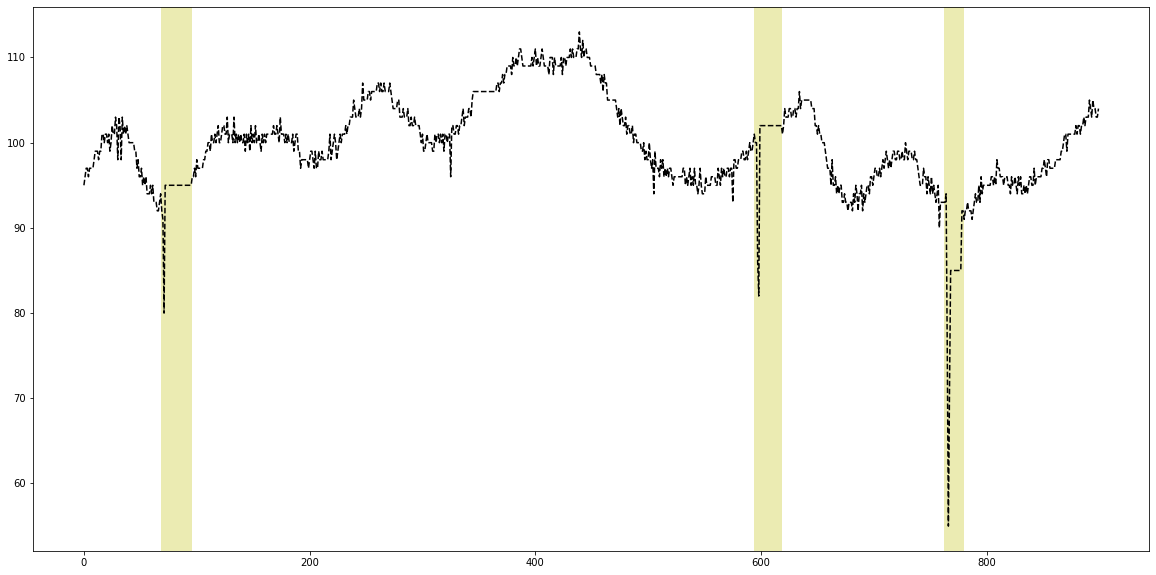

In [302]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")
for i,j in ans_blinks:
    plt.axvspan(xmin=i-2, xmax=j+2, facecolor="y", alpha=0.3)
plt.show()

合并眨眼区间

In [303]:
ans_blinks_1 = blinks_merge(ans_blinks,distance=100, remove_signal=False)

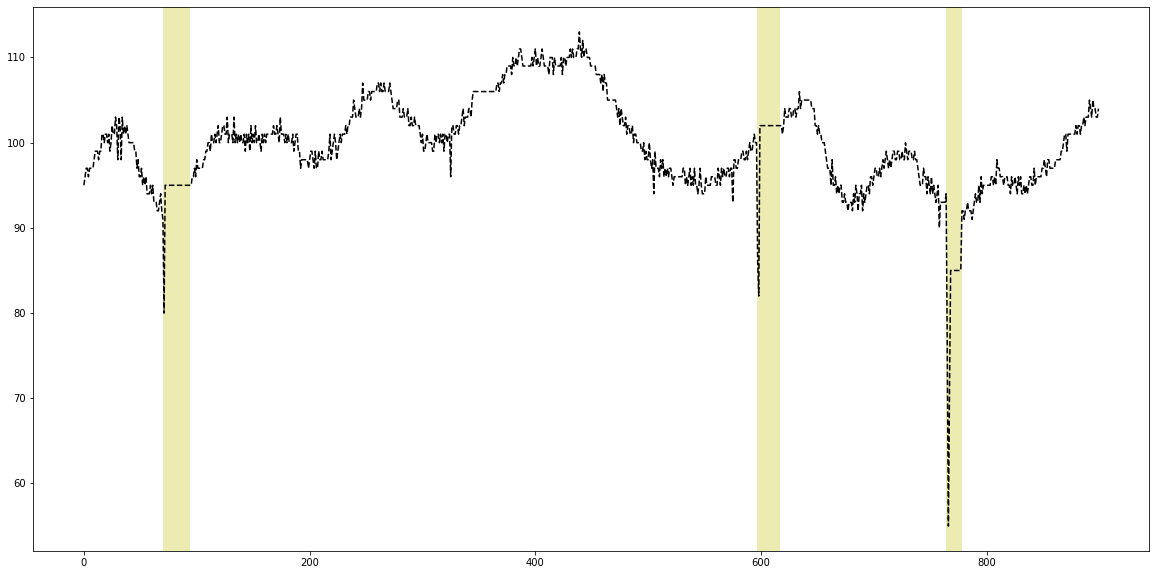

In [304]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")
for i,j in ans_blinks_1:
    plt.axvspan(xmin=i, xmax=j, facecolor="y", alpha=0.3)
plt.show()
# 合并成功

In [305]:
interpolated_mask=np.zeros(temp_seg.shape[0])
interpolated_mask.shape

(900,)

In [306]:
interpolated_mask=np.zeros(temp_seg.shape[0])
for on,off in ans_blinks_1:
    interpolated_mask[on:off]=1

In [307]:
temp_seg.index[interpolated_mask==0]

DatetimeIndex(['2021-11-04 08:07:50.865000', '2021-11-04 08:07:50.875000',
               '2021-11-04 08:07:50.885000', '2021-11-04 08:07:50.895000',
               '2021-11-04 08:07:50.905000', '2021-11-04 08:07:50.915000',
               '2021-11-04 08:07:50.925000', '2021-11-04 08:07:50.935000',
               '2021-11-04 08:07:50.945000', '2021-11-04 08:07:50.955000',
               ...
               '2021-11-04 08:07:59.765000', '2021-11-04 08:07:59.775000',
               '2021-11-04 08:07:59.785000', '2021-11-04 08:07:59.795000',
               '2021-11-04 08:07:59.805000', '2021-11-04 08:07:59.815000',
               '2021-11-04 08:07:59.825000', '2021-11-04 08:07:59.835000',
               '2021-11-04 08:07:59.845000', '2021-11-04 08:07:59.855000'],
              dtype='datetime64[ns]', name='timestamp', length=841, freq=None)

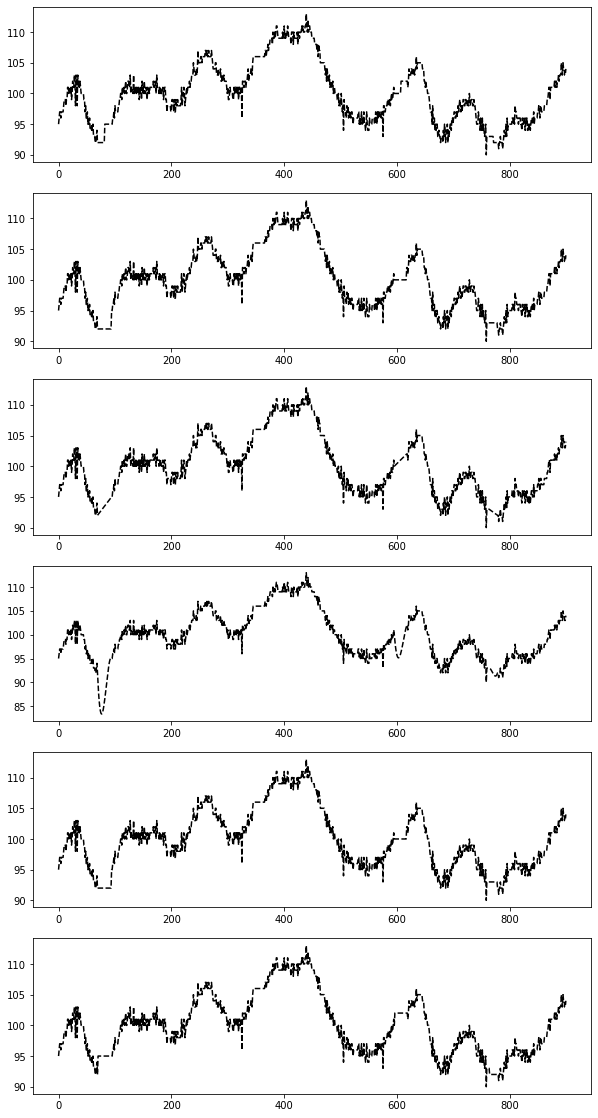

In [308]:
plt.figure(figsize=(10,20))
kind_lst = ['nearest', 'zero', 'slinear', 'cubic', 'previous',  'next']
for k in range(len(kind_lst)):
    f=scipy.interpolate.interp1d(np.float64(temp_seg.index.values)[interpolated_mask==0], temp_seg_inter_1[interpolated_mask==0], 
                                 kind=kind_lst[k], bounds_error=False, fill_value=0)
    temp_seg_inter_2 = f(np.float64(temp_seg.index.values))
    plt.subplot(len(kind_lst),1,k+1)
    plt.plot(range(900),temp_seg_inter_2,color="black",linestyle="--",label=kind_lst[k])

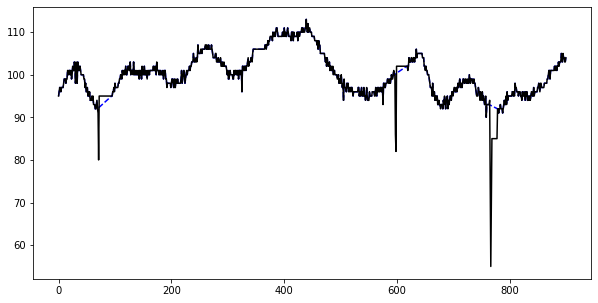

In [312]:
# 画图
f=scipy.interpolate.interp1d(np.float64(temp_seg.index.values)[interpolated_mask==0], temp_seg_inter_1[interpolated_mask==0], 
                                 kind='slinear', bounds_error=False, fill_value=0)
temp_seg_inter_2 = f(np.float64(temp_seg.index.values))

plt.figure(figsize=(10,5))
plt.plot(range(900),temp_seg_inter_2,color="blue",linestyle="--")
plt.plot(range(900),temp_seg_inter_1,color="black")


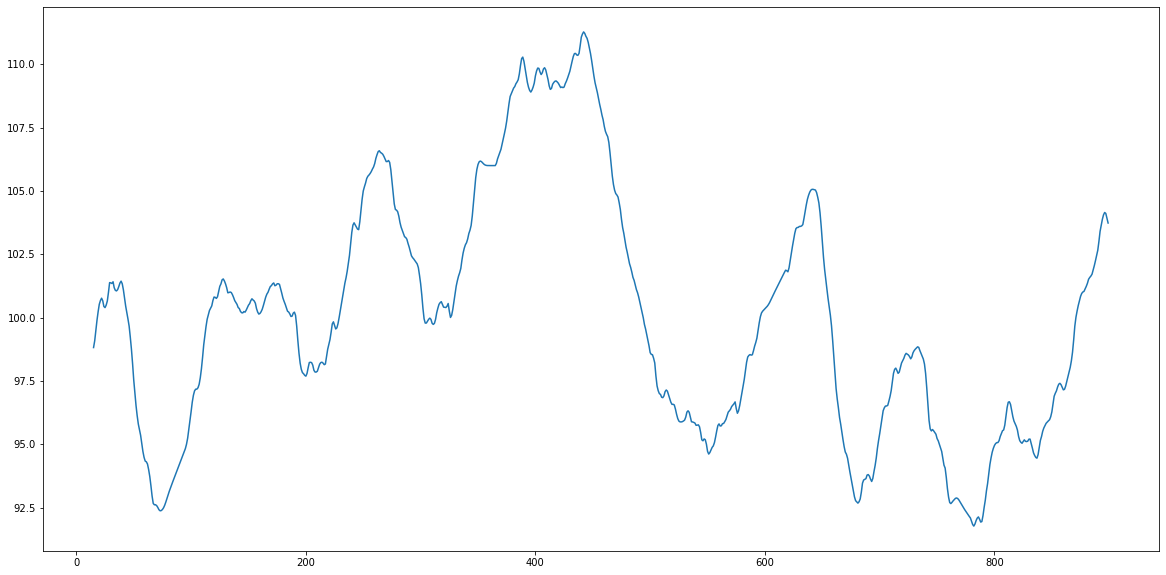

In [320]:
####HMA#####
# https://stackoverflow.com/questions/64500904/how-to-calculate-hull-moving-average-in-python
a = pd.DataFrame(columns=["pupil_size"],data = temp_seg_inter_2)
b = HMA_pupil(a,period = 8)
plt.figure(figsize=(20,10))
plt.plot(b.values)

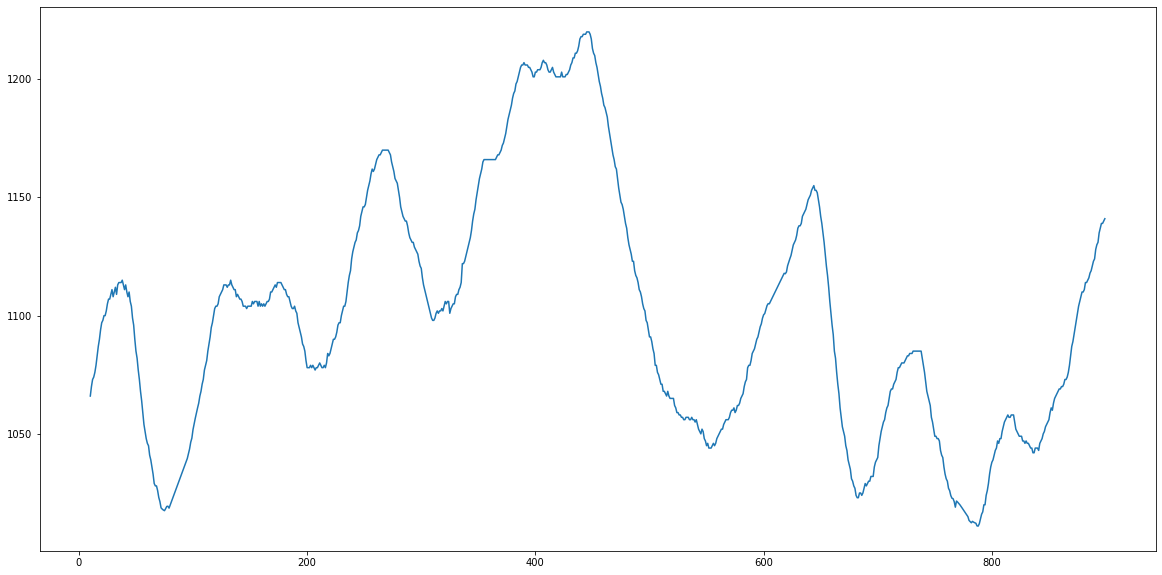

In [319]:
###### 移动平均滤波  #####
# def move_average(df,window_size = 5):
#     return df.rolling(window = window_size).sum()
a = pd.DataFrame(columns=["pupil_size"],data = temp_seg_inter_2)
b = move_average(a,window_size =11)
plt.figure(figsize=(20,10))
plt.plot(b.values)

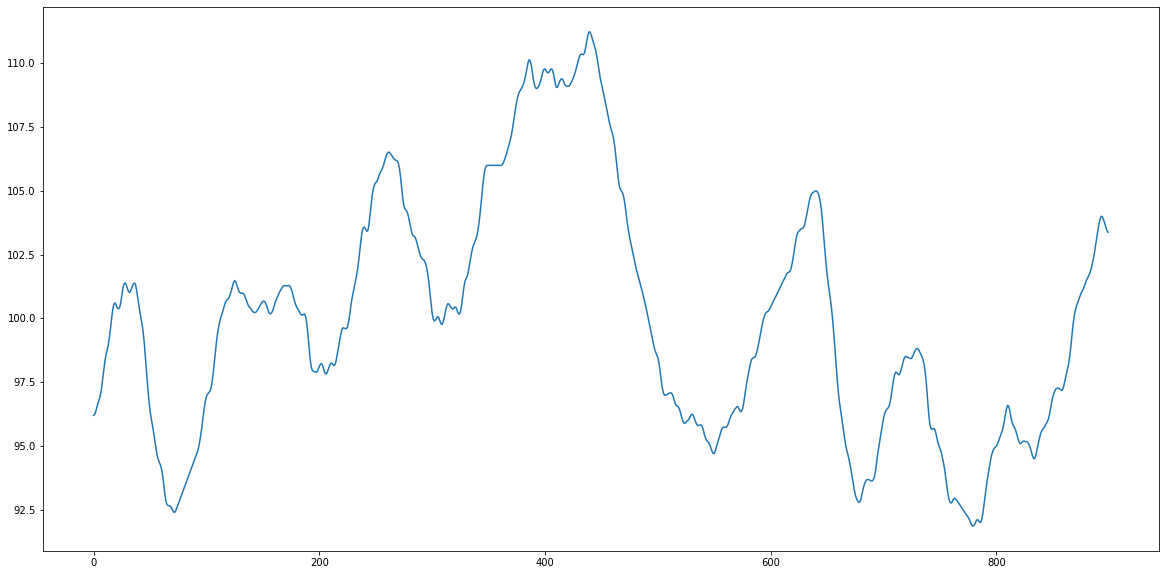

In [315]:
##### 信号处理 #######
b = smooth_window(temp_seg_inter_2,window_len=11)
plt.figure(figsize=(20,10))
plt.plot(range(900),b)

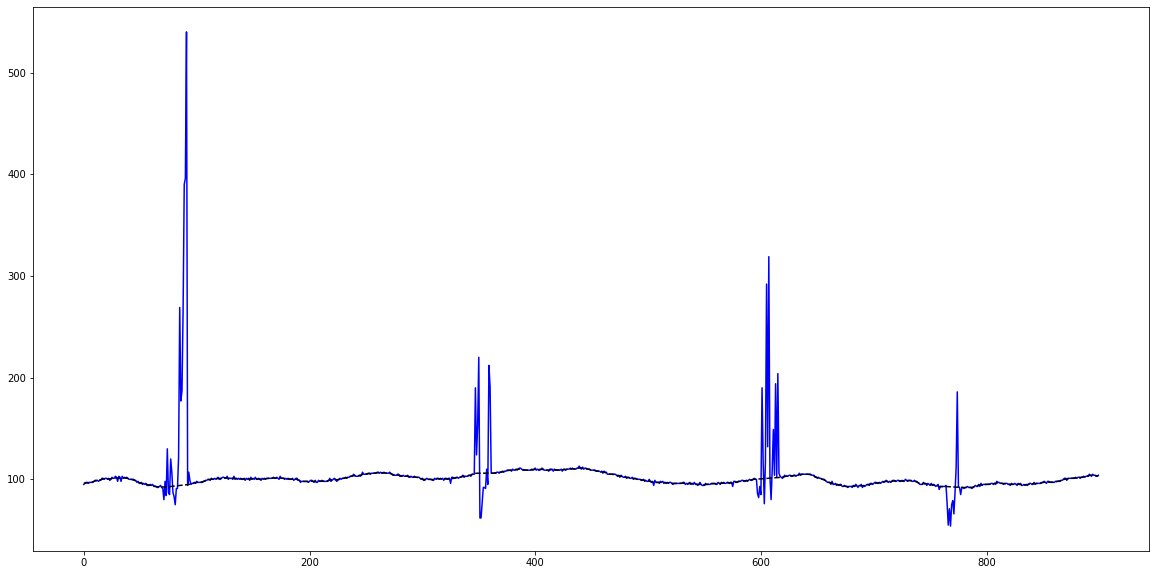

In [329]:
temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[1])
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg["pupil_size"],color="blue")
b = smooth_window(temp_seg_inter_2,window_len=11)

plt.plot(range(900),b,color="black",linestyle="--")

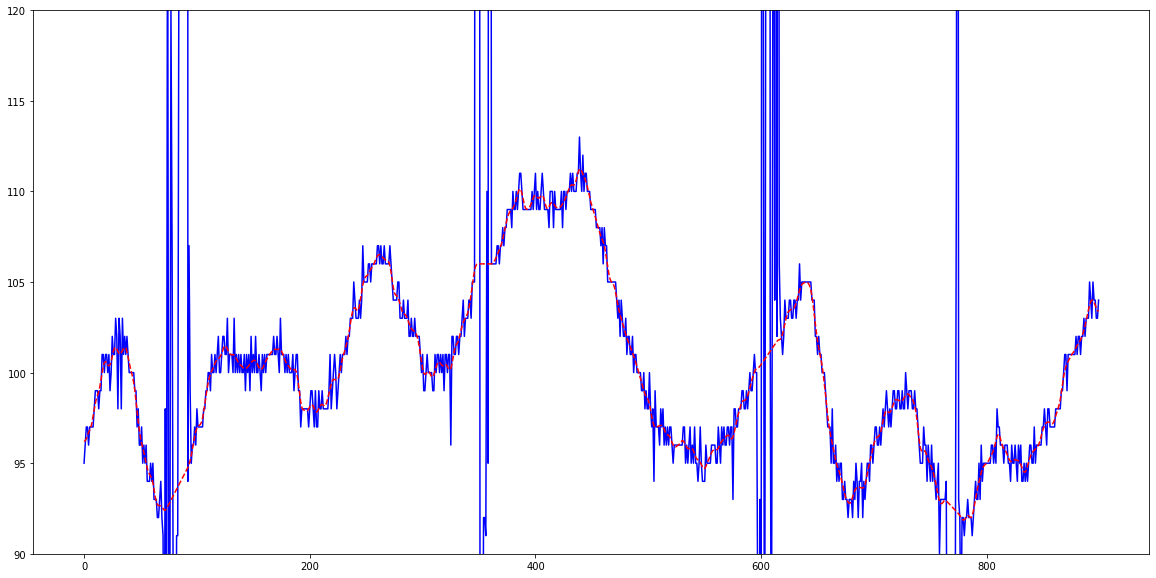

In [330]:
temp_seg,_ = get_trail_segment(pupil_data,pupil_event,[1])
plt.figure(figsize=(20,10))
plt.ylim(90, 120)
plt.plot(range(900),temp_seg["pupil_size"],color="blue")
b = smooth_window(temp_seg_inter_2,window_len=11)

plt.plot(range(900),b,color="red",linestyle="--")

In [104]:
sym=smooth_window(temp_seg_inter_1, window_len=7,window='hanning')
vel=np.r_[0,np.diff(sym)] # 在累差前面添加一个0

In [123]:
np.set_printoptions(precision=3, suppress=True)
vel[560:610]

array([-0.167,  0.167,  0.25 ,  0.083, -0.   ,  0.167,  0.25 , -0.   ,
       -0.083,  0.083,  0.167,  0.083,  0.   , -0.25 , -0.417,  0.   ,
        0.583,  0.667,  0.167,  0.   ,  0.25 ,  0.333,  0.333,  0.25 ,
        0.   , -0.167, -0.083,  0.083,  0.25 ,  0.333,  0.25 ,  0.083,
        0.167,  0.417,  0.333, -1.167, -4.   , -4.083,  0.167,  4.5  ,
        4.667,  1.667,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ])

In [205]:
vel_offset =2
min_offset_len = 15

In [231]:
offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0]
offsets

array([  0,  31,  58,  60,  68,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
       119, 126, 165, 169, 175, 196, 202, 266, 271, 282, 292, 305, 319,
       329, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 368, 387, 392, 393, 394, 461, 467, 468, 469,
       517, 523, 526, 527, 528, 554, 558, 579, 584, 599, 600, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       623, 626, 628, 631, 636, 639, 640, 641, 642, 669, 670, 680, 720,
       722, 729, 731, 767, 768, 769, 771, 772, 773, 774, 775, 778, 800,
       801, 821, 835, 844, 875, 876, 882, 893, 895, 899], dtype=int64)

In [232]:
offsets_ixx=np.r_[np.diff(offsets),5]>1
offsets_ixx

array([ True,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False, False, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [233]:
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets_len

array([ 0, 31, 27,  2,  8,  5, 20, 26,  7, 39,  4,  6, 21,  6, 64,  5, 11,
       10, 13, 14, 10, 34,  5, 19,  7, 67,  8, 48,  6,  5, 26,  4, 21,  5,
       16, 16,  7,  3,  2,  3,  5,  6, 28, 10, 40,  2,  7,  2, 38,  6,  3,
       23, 20, 14,  9, 32,  6, 11,  2,  4], dtype=int64)

In [234]:
offsets=offsets[offsets_ixx]
offsets

array([  0,  31,  58,  60,  68,  73,  93, 119, 126, 165, 169, 175, 196,
       202, 266, 271, 282, 292, 305, 319, 329, 363, 368, 387, 394, 461,
       469, 517, 523, 528, 554, 558, 579, 584, 600, 616, 623, 626, 628,
       631, 636, 642, 670, 680, 720, 722, 729, 731, 769, 775, 778, 801,
       821, 835, 844, 876, 882, 893, 895, 899], dtype=int64)

In [215]:
a = np.array([])

In [216]:
a.append(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [217]:
offsets

array([ 31,  58,  93, 119, 165, 196, 266, 363, 387, 461, 517, 554, 579,
       600, 616, 670, 720, 769, 801, 821, 876], dtype=int64)

In [237]:
offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0]
min_offset_len = 20
temp = []
i,j =0,1
while i < len(offsets)-1 and j < len(offsets)-1:
    if offsets[j]-offsets[i]<min_offset_len:
        j+=1
        continue
    else:
        temp.append(offsets[j-1])
        i=j
        j+=1
temp        

[0,
 31,
 77,
 93,
 126,
 175,
 202,
 282,
 305,
 329,
 363,
 387,
 394,
 469,
 528,
 558,
 584,
 616,
 642,
 680,
 731,
 778,
 801,
 835,
 844,
 893]

In [ ]:
73, 600, 769

In [213]:
min_offset_len = 5

15

In [212]:
offsets=offsets[offsets_len>min_offset_len]
offsets

array([ 31,  58,  93, 119, 165, 196, 266, 363, 387, 461, 517, 554, 579,
       600, 616, 670, 720, 769, 801, 821, 876], dtype=int64)

In [ ]:
73, 600, 769

In [ ]:
offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0]
offsets_ixx=np.r_[np.diff(offsets),5]>1
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]
offsets

In [167]:
sym=smooth_window(temp_seg_inter_1, window_len=7,window='hanning')
vel=np.r_[0,np.diff(sym)] # 在累差前面添加一个0
# 选出速度合格的点的索引
offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
offsets_ixx=np.r_[offsets[0]-1,np.diff(offsets)]>5# 间隔大于1得索引
offsets=offsets[offsets_ixx]
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_len>min_offset_len]

127


array([  0,  31,  58,  60,  68,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
       119, 126, 165, 169, 175, 196, 202, 266, 271, 282, 292, 305, 319,
       329, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 368, 387, 392, 393, 394, 461, 467, 468, 469,
       517, 523, 526, 527, 528, 554, 558, 579, 584, 599, 600, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       623, 626, 628, 631, 636, 639, 640, 641, 642, 669, 670, 680, 720,
       722, 729, 731, 767, 768, 769, 771, 772, 773, 774, 775, 778, 800,
       801, 821, 835, 844, 875, 876, 882, 893, 895, 899], dtype=int64)

In [169]:

offsets_len

array([31, 27, 10, 51,  7, 39, 10, 21,  6, 64, 16, 10, 13, 14, 10, 19, 39,
       74,  6, 50,  6, 31, 25, 20, 24, 46, 11, 40,  9, 38, 33, 21, 14,  9,
       31,  7, 11], dtype=int64)

In [ ]:
73, 600, 769

In [172]:
offsets

array([ 31,  58,  68, 119, 126, 165, 175, 196, 202, 266, 282, 292, 305,
       319, 329, 348, 387, 461, 467, 517, 523, 554, 579, 599, 623, 669,
       680, 720, 729, 767, 800, 821, 835, 844, 875, 882, 893], dtype=int64)

In [173]:
min_offset_len = 30
offsets=offsets[offsets_len>min_offset_len]

In [174]:
offsets

array([ 31,  58, 119, 165, 196, 266, 282, 348, 387, 461, 517, 554, 579,
       599, 623, 669, 720, 767, 800, 821, 875], dtype=int64)

In [161]:
len(np.r_[offsets[0]-1,np.diff(offsets)])

127

In [162]:
np.r_[offsets[0]-1,np.diff(offsets)]>5

array([False,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False,  True,  True, False, False, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False])

In [152]:
# 获取选出点之间的距离
onsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])

In [155]:
onsets_ixx

array([ True,  True, False,  True, False, False])

In [154]:
onsets=onsets[onsets_ixx]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 6

In [145]:
offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
offsets

array([  0,  31,  58,  60,  68,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
       119, 126, 165, 169, 175, 196, 202, 266, 271, 282, 292, 305, 319,
       329, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 368, 387, 392, 393, 394, 461, 467, 468, 469,
       517, 523, 526, 527, 528, 554, 558, 579, 584, 599, 600, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       623, 626, 628, 631, 636, 639, 640, 641, 642, 669, 670, 680, 720,
       722, 729, 731, 767, 768, 769, 771, 772, 773, 774, 775, 778, 800,
       801, 821, 835, 844, 875, 876, 882, 893, 895, 899], dtype=int64)

In [146]:
offsets_ixx=np.r_[offsets[0]-1,np.diff(offsets)]>5# 间隔大于1得索引
offsets_ixx

array([False,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False,  True,  True, False, False, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False])

In [147]:
offsets=offsets[offsets_ixx]
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=onsets[offsets_len>min_offset_len]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 37 but corresponding boolean dimension is 127

In [144]:
offsets_len

array([31, 27, 10, 51,  7, 39, 10, 21,  6, 64, 16, 10, 13, 14, 10, 19, 39,
       74,  6, 50,  6, 31, 25, 20, 24, 46, 11, 40,  9, 38, 33, 21, 14,  9,
       31,  7, 11], dtype=int64)

In [140]:
offsets=onsets[offsets_len>min_offset_len]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 37

In [ ]:
offsets=np.where(vel>=vel_offset)[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
offsets_ixx=np.r_[offsets[0]-1,np.diff(offsets)]>1# 间隔大于1得索引
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_ixx]
offsets=onsets[offsets_len>min_offset_len]

In [119]:
# 选出所有导数符号要求的点的索引
offsets=np.where(vel>=vel_offset)[0]
offsets

array([ 72,  73, 599, 600, 767, 768, 769, 778], dtype=int64)

In [124]:
# 选出所有导数符号要求的点的索引
offsets=np.where(np.logical_or(vel>=vel_offset,vel==0))[0]
offsets

array([  0,  31,  58,  60,  68,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
       119, 126, 165, 169, 175, 196, 202, 266, 271, 282, 292, 305, 319,
       329, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 368, 387, 392, 393, 394, 461, 467, 468, 469,
       517, 523, 526, 527, 528, 554, 558, 579, 584, 599, 600, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       623, 626, 628, 631, 636, 639, 640, 641, 642, 669, 670, 680, 720,
       722, 729, 731, 767, 768, 769, 771, 772, 773, 774, 775, 778, 800,
       801, 821, 835, 844, 875, 876, 882, 893, 895, 899], dtype=int64)

In [126]:
# 检查速度的连续性
offsets_ixx=np.r_[np.diff(offsets),5]>2
offsets

array([  0,  31,  58,  60,  68,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
       119, 126, 165, 169, 175, 196, 202, 266, 271, 282, 292, 305, 319,
       329, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 368, 387, 392, 393, 394, 461, 467, 468, 469,
       517, 523, 526, 527, 528, 554, 558, 579, 584, 599, 600, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       623, 626, 628, 631, 636, 639, 640, 641, 642, 669, 670, 680, 720,
       722, 729, 731, 767, 768, 769, 771, 772, 773, 774, 775, 778, 800,
       801, 821, 835, 844, 875, 876, 882, 893, 895, 899], dtype=int64)

In [121]:
# 计算每个的间隔
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets_len

array([ 73, 527, 169,   9], dtype=int64)

In [122]:
min_offset_len = 15
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]
offsets

array([ 73, 600, 769], dtype=int64)

In [ ]:


offsets_ixx=np.r_[np.diff(offsets),5]>1
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]

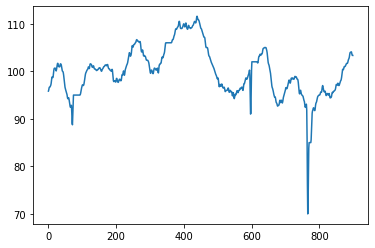

In [50]:
min_duration_ix = 5 
vel_onset = -2
min_onset_len = 5
sym=smooth_window(temp_seg_inter_1, window_len=7,window='hanning')
plt.plot(sym)
# 没问题

In [51]:
vel=np.r_[0,np.diff(sym)] # 在累差前面添加一个0
n=sym.size # 获得平滑后的长度
# vel是变化速度
# find first negative vel-crossing 
onsets=np.where(vel<=vel_onset)[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
onsets_ixx=np.r_[onsets[0]-1,np.diff(onsets)]>1# 间隔大于1得索引
onsets_len=np.diff(np.r_[0,onsets[onsets_ixx]])
onsets=onsets[onsets_ixx]
onsets=onsets[onsets_len>min_onset_len]
onsets

array([ 70, 596, 764], dtype=int64)

In [68]:
vel_offset =2
min_offset_len = 15
offsets=np.where(vel>=vel_offset)[0]
offsets_ixx=np.r_[np.diff(offsets),5]>1
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]
offsets

array([ 73, 600, 769], dtype=int64)

In [54]:
offsets

array([ 72,  73, 599, 600, 767, 768, 769, 778], dtype=int64)

In [65]:
np.r_[np.diff(offsets),5]

array([  1, 526,   1, 167,   1,   1,   9,   5], dtype=int64)

In [63]:
offsets_ixx=np.r_[np.diff(offsets),5]>1
offsets_ixx

array([False,  True, False,  True, False, False,  True,  True])

In [64]:
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets_len

array([ 73, 527, 169,   9], dtype=int64)

In [66]:
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]

In [67]:
offsets

array([ 73, 600, 769, 778], dtype=int64)

In [246]:
## offset finding
offsets=np.where(vel>=vel_offset)[0]
offsets_ixx=np.r_[onsets[0]-1,np.diff(offsets)]>1
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]
offsets

array([ 72, 599, 767, 778], dtype=int64)

In [248]:
vel_offset =2
min_offset_len = 15
## offset finding
offsets=np.where(vel>=vel_offset)[0]
offsets_ixx=np.r_[onsets[0]-1,np.diff(offsets)]>1
offsets_len=np.diff(np.r_[0,offsets[offsets_ixx]])
offsets=offsets[offsets_ixx]
offsets=offsets[offsets_len>min_offset_len]
offsets

array([ 72, 599, 767], dtype=int64)

In [251]:
blinks=[]
if len(onsets)<1:
    print("眨眼区间为0，需要重新调整")
on=onsets[0]
while on is not None:
    offs=offsets[offsets>on]
    off=offs[0] if offs.size>0 else n
    blinks.append([on,off])
    ons=onsets[onsets>off]
    on=ons[0] if ons.size>0 else None
## if on- off-sets fall in a zero-region, grow until first non-zero sample
blinks2=[]
for (on,off) in blinks:
    while(on>0 and temp_seg_inter_1[on]==0):
        on-=1
    while(off<n-1 and temp_seg_inter_1[off]==0):
        off+=1
    blinks2.append([on,off])
blinks3 = []
for (on,off) in blinks2:
    while(on>0 and np.diff(sym)[on]==0):
        on-=1
    while(off<n-1 and np.diff(sym)[on]==0):
        off+=1
    blinks3.append([on,off])
a = np.array(blinks2)

In [252]:
a

array([[ 70,  72],
       [596, 599],
       [764, 767]], dtype=int64)

In [228]:
onsets[onsets_ixx]

array([ 70, 596, 764], dtype=int64)

In [229]:
np.r_[0,onsets[onsets_ixx]]

array([  0,  70, 596, 764], dtype=int64)

In [230]:
onsets_len=np.diff(np.r_[np.r_[0,onsets[onsets_ixx]]])
onsets_len

array([ 70, 526, 168], dtype=int64)

In [231]:
onsets_ixx

array([ True,  True, False,  True, False, False])

In [232]:
onsets=onsets[onsets_ixx]
onsets

array([ 70, 596, 764], dtype=int64)

In [233]:
onsets_len

array([ 70, 526, 168], dtype=int64)

In [234]:
onsets_len>min_onset_len

array([ True,  True,  True])

In [235]:
onsets=onsets[onsets_len>min_onset_len]
onsets

array([ 70, 596, 764], dtype=int64)

In [182]:
onsets=onsets[onsets_len>min_onset_len]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 3

In [159]:
onsets_ixx=np.r_[onsets[0]-1,np.diff(onsets)]>5  


array([ 70, 526, 168], dtype=int64)

In [166]:
onsets_len=np.diff(np.r_[0,np.where(onsets_ixx)[0]]) 

In [170]:
onsets_len

array([0, 1, 2], dtype=int64)

In [169]:
np.where(onsets_ixx)

(array([0, 1, 3], dtype=int64),)

In [171]:
onsets=onsets[onsets_ixx]

In [172]:
onsets

array([ 70, 596, 764], dtype=int64)

In [ ]:
 onsets_ixx=np.r_[np.diff(onsets),10]>1  # 间隔大于1得索引
onsets_len=np.diff(np.r_[0,np.where(onsets_ixx)[0]])  
onsets=onsets[onsets_ixx]  # 速度符合要求的起始点
onsets=onsets[onsets_len>min_onset_len]  # 筛选每个起始点对应的长度，长度定义：一个起点到下一个起点的索引距离


In [155]:
onsets=onsets[onsets_ixx]
onsets=onsets[onsets_len>min_onset_len]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 6

In [ ]:
onsets=onsets[onsets_ixx]  # 速度符合要求的起始点
onsets=onsets[onsets_len>min_onset_len]  # 筛选每个起始点对应的长度，长度定义：一个起点到下一个起点的索引距离


In [ ]:
onsets=np.where(vel<=vel_onset)[0] # [0]很常见得元组转list手法，选出速度比阈值更小得点
onsets_ixx=np.r_[np.diff(onsets),10]>1  # 间隔大于1得索引
onsets_len=np.diff(np.r_[0,np.where(onsets_ixx)[0]])  
onsets=onsets[onsets_ixx]  # 速度符合要求的起始点
onsets=onsets[onsets_len>min_onset_len]  # 筛选每个起始点对应的长度，长度定义：一个起点到下一个起点的索引距离


IndexError: index 0 is out of bounds for axis 0 with size 0

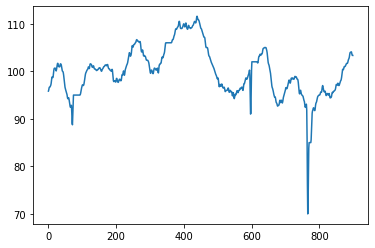

In [126]:
def easy_detect(data):
    min_duration_ix = 5  # 一个眨眼的持续时间不能小于5个采样单位
    blinks_vel= detect_blinks_velocity(data, smooth_winsize=7, vel_onset=-2, vel_offset=2, min_onset_len=5, min_offset_len=5)
    blinks = blinks_vel
    ans_blinks=np.array([[on,off] for (on,off) in blinks if off-on>=min_duration_ix])

    ans_blink_mask=np.zeros(data.size, dtype=np.int)

    for start,end in ans_blinks:
        ans_blink_mask[start:end]=1
    return ans_blinks,ans_blink_mask
ans_blinks,ans_blink_mask = easy_detect(temp_seg_inter_1)
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")
for i,j in ans_blinks:
    plt.axvspan(xmin=i, xmax=j, facecolor="y", alpha=0.3)
plt.show()

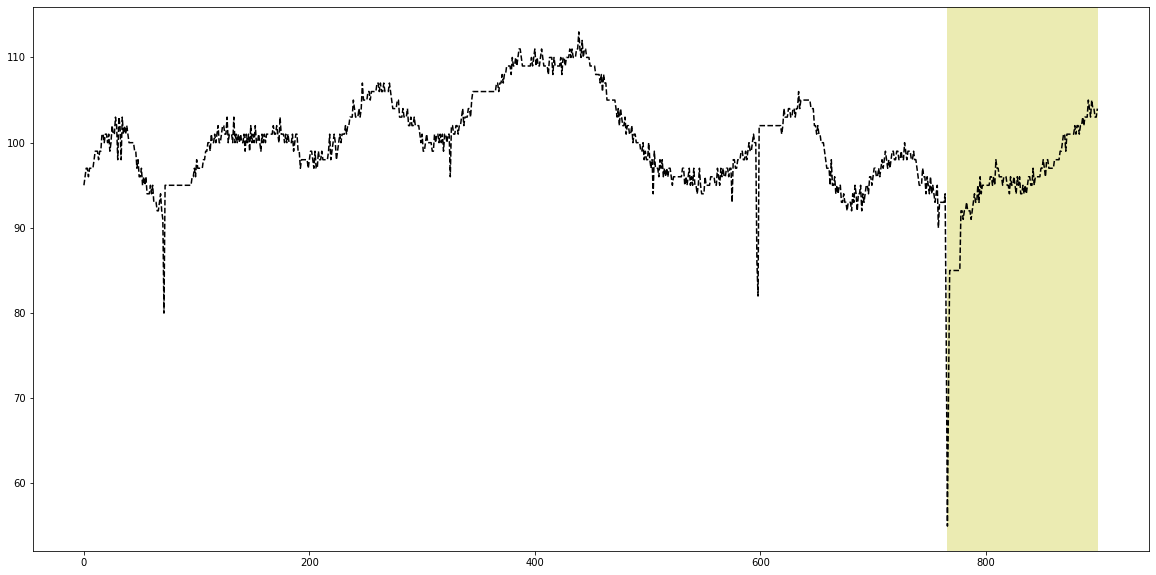

In [113]:
blinks2

array([[766, 900]], dtype=int64)

In [106]:
# 核心的眨眼检测
def blinks_detect(data,min_duration_ms: float=20,strategies=["velocity"]):
    """
    min_duration的计算公式 一次眨眼0.2s=200ms     200/1000*100 = 20  这里的100是采样率  
    """
    winsize_ix = 9
    vel_onset = -3
    vel_offset = 3
    min_duration_ix=int(min_duration_ms/1000.*fs)
    min_onset_len, min_offset_len =1,1
    ## detect blinks with the different strategies
    if "velocity" in strategies:
        blinks_vel=detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
    else: 
        blinks_vel=np.array([])
    if "reverse_velocity" in strategies:
        blinks_vel_2=reverse_detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)
    else: 
        blinks_vel_2=np.array([])
    # 用不上没有0值
#     if "zero" in strategies:
#         blinks_zero=detect_blinks_zero(data, 1)
#     else:
#         blinks_zero=np.array([])



#     for strat in strategies:
#         if strat == "velocity": 
#             blinks_vel=detect_blinks_velocity(data, winsize_ix, vel_onset, vel_offset, min_onset_len, min_offset_len)    
#         elif "zero" in strategies:
#             blinks_zero=detect_blinks_zero(data, 1, blink_val)
#         else:
#             blinks_zero=np.array([])
    # 将眨眼区间融合
    ## merge the two blinks，将两个眨眼算法融合
#     blinks=helper_merge_blinks(blinks_vel, blinks_zero)
###################################
# 将眨眼区间融合
    # merge the two blinks，将两个眨眼算法融合
#     blinks=helper_merge_blinks(blinks_vel,blinks_vel_2)
###################################
#     blinks = blinks_vel
    blinks = blinks_vel
    ans_blinks=np.array([[on,off] for (on,off) in blinks if off-on>=min_duration_ix])

    ans_blink_mask=np.zeros(data.size, dtype=np.int)

    for start,end in ans_blinks:
        ans_blink_mask[start:end]=1
    return ans_blinks,ans_blink_mask

In [107]:
ans_blinks,ans_blink_mask = blinks_detect(temp_seg_inter_1,min_duration_ms=20,strategies=["velocity"])

c:\users\wqj\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


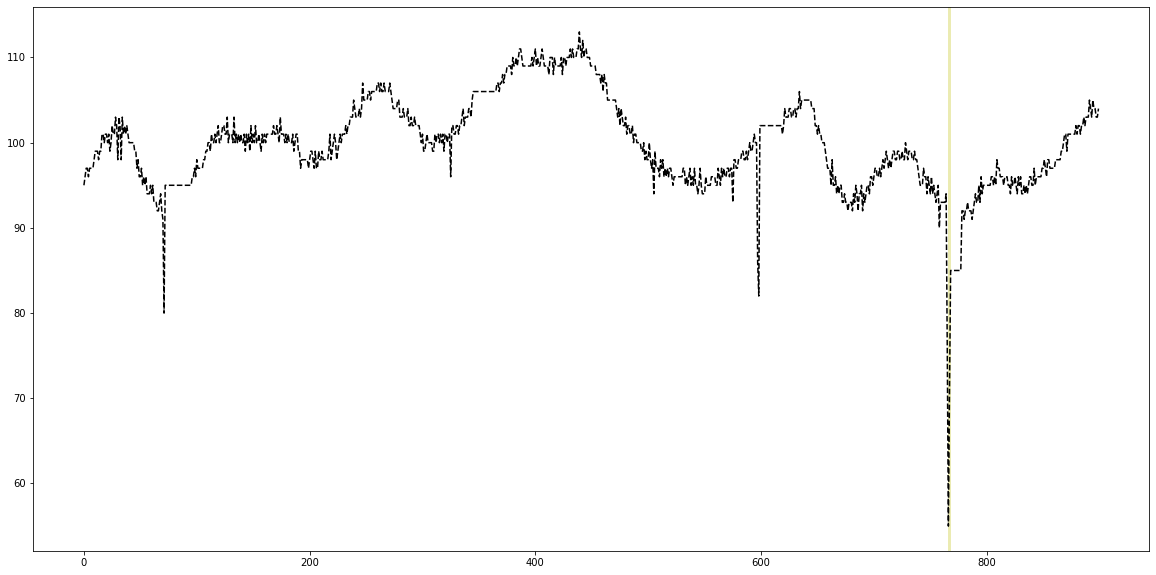

In [108]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(range(900),temp_seg_inter_1,color="black",linestyle="--")
for i,j in ans_blinks:
    plt.axvspan(xmin=i, xmax=j, facecolor="y", alpha=0.3)
plt.show()